# **From stellar stream/DM subhalos encounters to power spectrum: the power spectrum of Palomar 5**

# Description and Libraries

Like the stream_sim_galpy notebook, this notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential, and have the same dependencies, apart from the galpy extension streampepperdf.py which allow the user to perform multiple DMS impact for one stellar stream pdf generation. To use it, the user must DL the python extension at https://gist.github.com/jobovy/1be0be25b525e5f50ea3 and add it to the galpy df folder, update the \_init\_.py file and change:

 "from galpy.util import bovy_conversion, bovy_coords" (because it is deprecated) to\
 "import galpy.util.conversion as bovy_conversion\
  import galpy.util.coords as bovy_coords"

It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

Libraries

In [1]:
###Libraries
#Mains
# %matplotlib widget
%matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()

In [386]:
###Librairires for simulation and 
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities
from galpy.df import streampepperdf #Extension to perform multiple impact
import stream_galsim.impact_distribution as sid; reload(sid)

<module 'stream_galsim.impact_distribution' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py'>

# Simulation

## Initialization

The goal here is to compute a power spectrum of a simulated stellar stream, by mimicking as much as we can the properties of an existing stellar stream. At first we set the properties of the unperturbed system, including a progenitor (usually a globular cluster) and an accreting host in which it is stripped.

Physical quantities

In [3]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)
# print(stream_data)
#only progenitor data is wanted for our simulation
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
#["dec","dec_unit","distance","distance_unit","frame","pm_dec","pm_dec_unit","pm_ra_cosdec","pm_ra_cosdec_unit", "ra","ra_unit","radial_velocity","radial_velocity_unit"]
print(progenitor.values.tolist()[0])

['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]


In [4]:
###Progenitor
#progenitor coord 
cluster_name = progenitor.values.tolist()[0][0] #name
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS


prog_mass = 2*10.**4.*u.Msun
prog_a = 20.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
prog_sigv = 0.365 *u.km/u.s
t_disrupt = 4*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

In [5]:
###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=0.8)

Simulating the unperturbed model

In [6]:
#NonPerturbedStreamModel class from sid
SmoothStreamdf = sid.NonPerturbedStreamModel(sigv = prog_sigv,
            progenitor=prog_orbit,
            pot=mw_pot,
            aA=aaisochrone,
            leading=True,
            ro = R0, #Distance scale for translation into internal units
            vsun=vsun,
            tdisrupt=t_disrupt)

In [7]:
###Retrieve significant data from unperturbed streamdf
smooth_length_kpc = SmoothStreamdf.stream_length(threshold=0.2, phys=True)
smooth_length_deg = SmoothStreamdf.stream_length(threshold=0.2, phys=False)
print(smooth_length_kpc, 'kpc', smooth_length_deg, '°')
r_avg, r_max, r_min = SmoothStreamdf.compute_r_avg_max()
# d_omega_par = SmoothStreamdf.compute_average_Omega_parallel()
d_omega_par = SmoothStreamdf.estimate_Omega_parallel()
print(r_avg, r_max, r_min, d_omega_par,t_disrupt)


7.684721447910638 kpc 1.5030382746695914 °
16.60508409274332 18.76928666469285 11.05778443448257 0.37575956866739785 4.0 Gyr


In [8]:
sdf = SmoothStreamdf.streamdf()
print(isinstance(smooth_length_deg, u.Quantity))

False


## Statistical sampling of a DM subhalos distribution

We want to align the simulation as closely as possible with real astrophysical data. Therefore, it is necessary to define a realistic environment for creating a disturbed flow. We already have the progenitor and an accreting host, but we do not have a precise distribution of the DMS in the latter. 

- At first we sample a distribution of subhalos for the considered galactical/cosmological model (DMS_distribution class). 
- Then we compute an expected number of encounters within the stellar stream and the subhalos (N_encounter function). 
- Finally, we sample the distribution of impact parameters, considering the DMS distribution and the smooth stream model computed already.


Considered properties and parameters in the model:
- the impact time ti;
- the angle parallel to the flow at which the impact occurs at the time of closest approach;
- the flyby velocity of the dark matter halo;
- the impact parameter;
- the intrinsic properties of the subhalo (mass, density profile, and radius).
- the mass range considered (Mmin,Mmax)


In [9]:
#DMS_Distribution class from sid
### Tests on Nenc
Mmin, Mmax = 1e5, 1e9
sigma_h = 150*u.km/u.s
dms = sid.DMS_Distribution(profile='einasto')#profile reffers here to th MW density profile 
bmax = dms.bmax_inmassrange(Mmin, Mmax, alpha=3,profile='NFW')
print(f"{bmax:.2f}")
n_h = dms.density_involume_inmassrange(r_min, r_max, Mmin, Mmax)
N_h = dms.number_involume_inmassrange(r_min, r_max, Mmin, Mmax)
print(f"{n_h}", f"{N_h:.1f}")


Galactic parameters: 
 alpha = 0.678 | r_minus2 = 199 | rs = 21 
 galactic radius = 300.0, galactic profile = einasto
subhalo profile: NFW
0.70 kpc
0.013368175254536256 1 / kpc3 294.5


In [10]:
###Librairires for simulation and 
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities
from galpy.df import streampepperdf #Extension to perform multiple impact
import stream_galsim.impact_distribution as sid; reload(sid)

<module 'stream_galsim.impact_distribution' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py'>

In [11]:
#N_encounter from sid
# N_enc = sid.expected_N_encounters(r_avg=r_avg, sigma_h=sigma_h, t_d=t_disrupt, delta_omega=d_omega_par/5, b_max=bmax, n_h=n_h)
N_enc = sid.expected_N_encounters(sigma_h=sigma_h, t_d=t_disrupt, b_max=bmax, n_h=n_h, phys_length=smooth_length_kpc, use_phys_length = True)
print(N_enc)

38.89577403190081


In [46]:
#ImpactSampler class from sid
mass_range = (Mmin,Mmax)*u.Msun
SIS = sid.ImpactSampler(float(N_enc), mass_range, sigma_h, tdisrupt=t_disrupt*0.90, stream_length=smooth_length_deg*1.1, use_phys_length=False, profile='NFW')
impact_list = SIS.impact_list()

False
Generating 30 impacts between the stream and subhalos


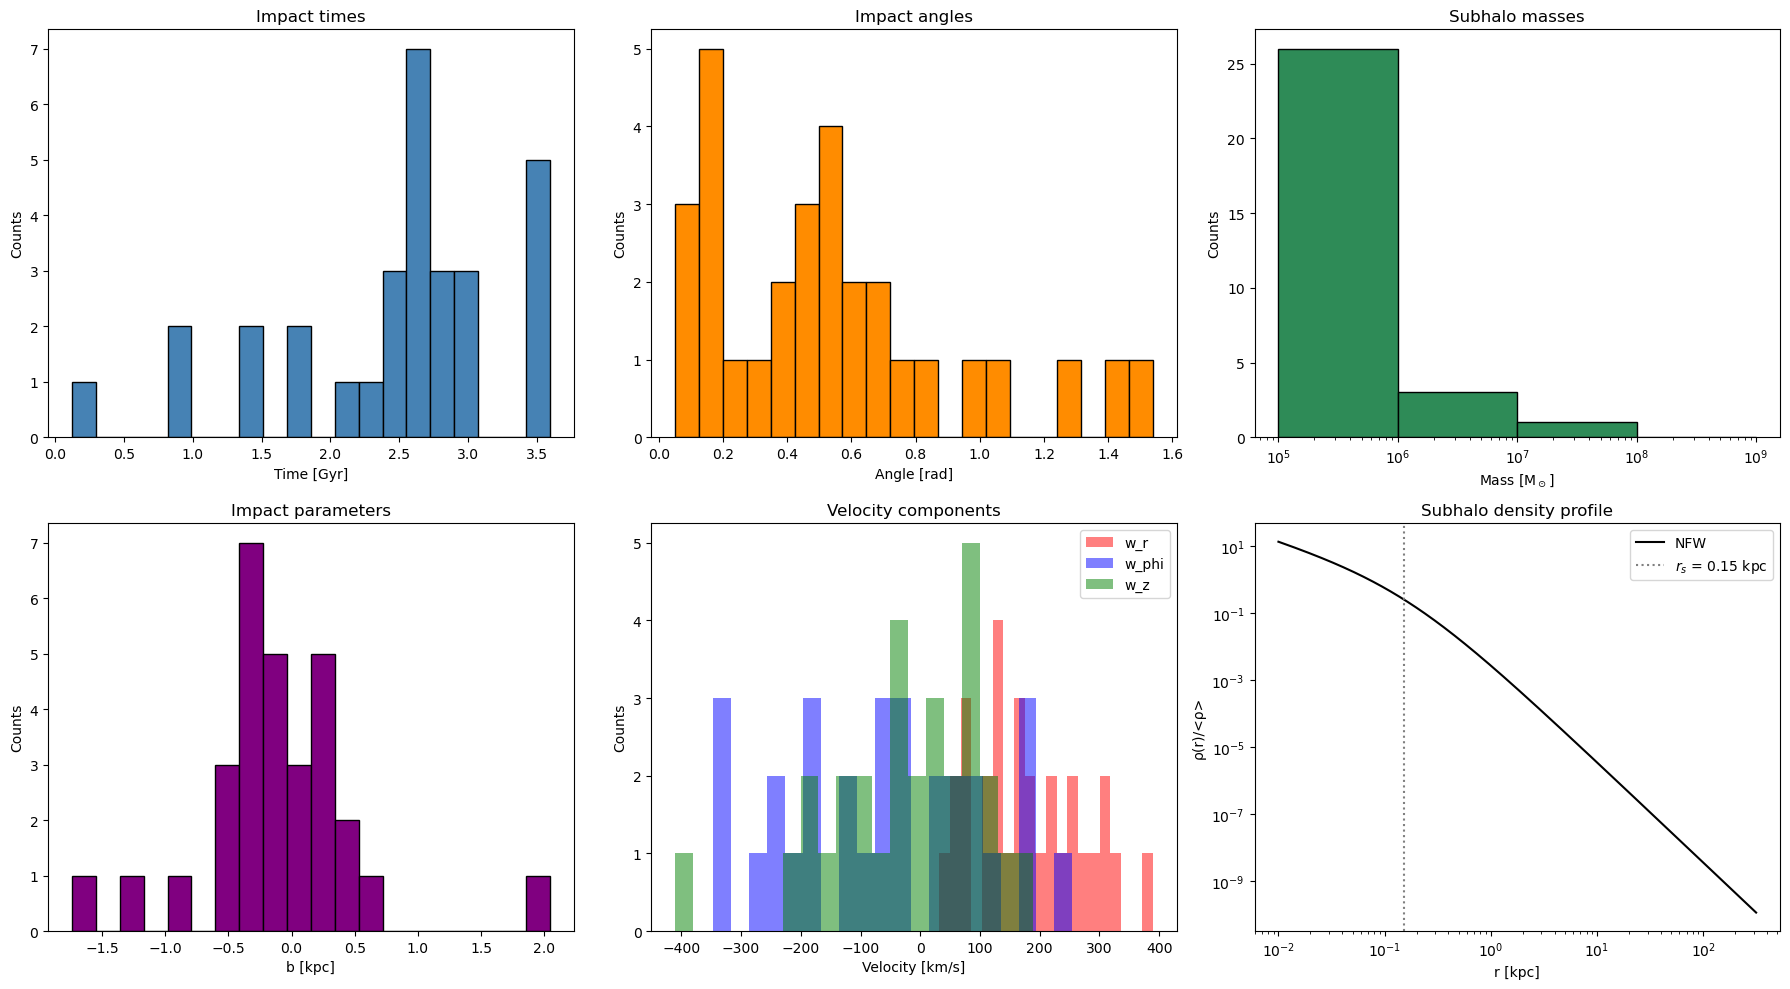

t, theta, m, b, w_r,w_phi,w_z, shpot


In [47]:
%matplotlib inline
impact_list.plot_distributions()
impactlist = impact_list.values()

In [48]:
impactlist[impactlist[:,2]>10000000]

array([[2.561234363555144, 0.7491983157624594, 12487450.275315547,
        2.043835259349172, 70.45617136120777, 164.6314718248875,
        -168.47462051825983,
      dtype=object)

## Simulation of the peppered stream df

Now that we have a physical distribution of impacts, we can simulate those impact onto the smooth stream df.

stream peppered pdf

In [49]:
spdf = streampepperdf(
    sigv=prog_sigv,
    progenitor=prog_orbit,
    pot=mw_pot,
    aA=aaisochrone,
    leading=True,
    tdisrupt=t_disrupt,
    nTrackChunks=26,
    ro=R0,
    vsun=vsun,
    timpact=impactlist.T[0],  # en Gyr
    impact_angle=impactlist.T[1],  # en radians
    subhalopot = impactlist.T[7],
    # impactb=impact_list.T[3],  # en kpc
    # GM=impactlist.T[2]*6.67*10e-11,  # GM en unités galpy
    # rs=impactlist.T[3]/5  # rs en unités galpy
)

/home/hallouin/miniconda3/envs/streams/lib/python3.13/site-packages/galpy/df/streamgapdf.py:1554: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(_a_integrand, -1.0, 1.0, args=(y, b, w, pot, i))[0]



Sampling and proper coordinates

In [51]:
### The stream pepper df function does not provide a sampling in usual corrdinate system.
#Thus from the sampling in aA coordinates and the sat isocrhone approx,
#we go back to usual coordinate systems as galctocentric cylindrical or rectangular
def sample_xyz(sdf, n=1000):
    """
    Returns the Cartesian Galactocentric coordinates (X, Y, Z) in kpc
    for n stars in the perturbed stream.

    Returns
    -------
    xyz : np.ndarray, shape (n, 3)
        Colonnes : X, Y, Z en kpc
    """
    Om, angle, _ = sdf._sample_aAt(n)
    ro = sdf._ro
    vo = sdf._vo
    
    # Convertir (Omega, angle) → (R, vR, vT, z, vz, phi)
    RvR = sdf._approxaAInv(
        Om[0], Om[1], Om[2],
        angle[0], angle[1], angle[2]
    )
    
    R = RvR[0] * ro
    phi = RvR[5]
    Z = RvR[3] * ro

    X = R * np.cos(phi)
    Y = R * np.sin(phi)

    return np.vstack((X, Y, Z)).T  # shape (n, 3)


Unperturbed stream

In [52]:
##sampling
np.random.seed(4)
xyz_s = sample_xyz(sdf, n=40000)
X_s, Y_s, Z_s = np.array(xyz_s.T[:3])* u.kpc
X_s = -X_s #galpy use lefthanded frame, we use righthanded x-> -x
with ac.galactocentric_frame_defaults.set("v4.0"):  # Use latest MW parameters
    galcen_s = ac.Galactocentric(x=X_s, y=Y_s, z=Z_s)

In [53]:
##conversion
#radec
icrs_s = sutils.xyz_to_icrs(xyz_s.T, velocities = False)

#phi12
ra_prog, dec_prog = progenitor.loc[:,['ra']].values.tolist()[0], progenitor.loc[:,['dec']].values.tolist()[0]
pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=218.5*u.deg, dec=-12.5*u.deg)

phi12_s = sutils.icrs_to_phi12(icrs_s, pole1, pole2, velocities = False)
phi12_s

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec) in deg
    (319.10291732, -39.69188176)>, origin=<ICRS Coordinate: (ra, dec) in deg
    (229., -0.124)>, priority=origin): (phi1, phi2, distance) in (deg, deg, kpc)
    [( 3.55538375, -0.42030011, 22.41703743),
     ( 0.05407279,  0.33403177, 23.02294385),
     ( 1.5078685 , -0.09839939, 22.86749863), ...,
     (10.36503416, -0.61893361, 20.82997775),
     (23.93152081,  2.03822331, 17.12599699),
     (10.08880225, -0.88374725, 20.96261668)]>

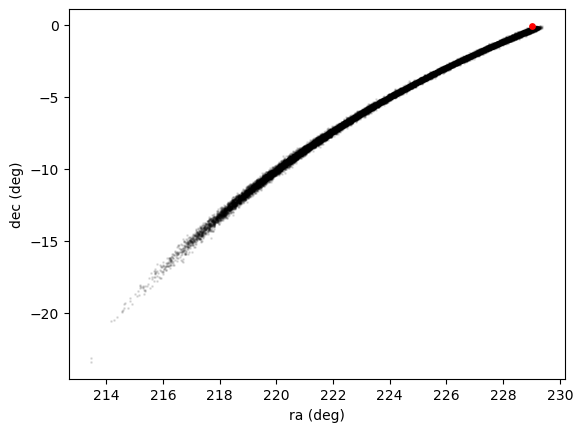

In [54]:
###Plot
## plot the track in the radec frame to see how it would appears from an observer on earth

plt.figure()
plt.scatter(icrs_s.ra.deg, icrs_s.dec.deg, s=1, c='k', alpha=0.1)
plt.scatter(ra_prog, dec_prog, s=15, c='r')#progenitor
plt.xlabel("ra (deg)")
plt.ylabel("dec (deg)")
# plt.title("Stellar Stream (ICRS)")

# sns.jointplot(x=phi12_s.phi1, y=phi12_s.phi2, alpha=0.1,s=5, color='k')
# # ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
# plt.xlabel(r"$\phi_2$ (deg)")
# plt.ylabel(r"$\phi_2$ (deg)")
# plt.xlabel("Phi1 (deg)")
# plt.ylabel("Phi2 (deg)")

plt.show()

In [55]:
#phi12
pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=218.5*u.deg, dec=-12.5*u.deg)
phi12_s = sutils.icrs_to_phi12(icrs_s, pole1, pole2, velocities = False)
phi12_s

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec) in deg
    (319.10291732, -39.69188176)>, origin=<ICRS Coordinate: (ra, dec) in deg
    (229., -0.124)>, priority=origin): (phi1, phi2, distance) in (deg, deg, kpc)
    [( 3.55538375, -0.42030011, 22.41703743),
     ( 0.05407279,  0.33403177, 23.02294385),
     ( 1.5078685 , -0.09839939, 22.86749863), ...,
     (10.36503416, -0.61893361, 20.82997775),
     (23.93152081,  2.03822331, 17.12599699),
     (10.08880225, -0.88374725, 20.96261668)]>

In [212]:
config = {
    "name": "Bressan2012",
    "survey": "des",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}
isochrone_model = sutils.IsochroneModel(config)

mag_g_s, mag_r_s = isochrone_model.sample_magnitudes(phi12_s, addnoise=True, sigma_mag=0.01)
# Save stars table with sampled magnitudes
sutils.save_star_data(phi12_s, mag_g_s, mag_r_s, 'phi12', filepath=f"/home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Smooth_Pal5_stars.csv")

Pandas DataFrame saved to: /home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Smooth_Pal5_stars.csv


,phi1,phi2,dist,mu1,mu2,rv,mag_g,mag_r
0,3.555384,-0.420300,22.417037,NaN,NaN,NaN,29.907471,28.347153
1,0.054073,0.334032,23.022944,NaN,NaN,NaN,30.354434,28.757828
2,1.507869,-0.098399,22.867499,NaN,NaN,NaN,28.189888,26.867965
3,14.763345,-0.433500,19.699225,NaN,NaN,NaN,28.565723,27.129538
4,10.228845,-0.751314,20.830647,NaN,NaN,NaN,29.564880,28.006860
...,...,...,...,...,...,...,...,...
39995,11.949094,-0.601168,20.385584,NaN,NaN,NaN,21.391510,21.122866
39996,14.774641,-0.379543,19.568116,NaN,NaN,NaN,27.449028,26.154667
39997,10.365034,-0.618934,20.829978,NaN,NaN,NaN,29.536910,27.997915
39998,23.931521,2.038223,17.125997,NaN,NaN,NaN,31.212969,29.426927


perturbed stream

In [183]:
##sampling
np.random.seed(4)
xyz_ps = sample_xyz(spdf, n=100000)
X_ps, Y_ps, Z_ps = np.array(xyz_ps.T[:3])* u.kpc
X_ps = -X_ps #galpy use lefthanded frame, we use righthanded x-> -x
with ac.galactocentric_frame_defaults.set("v4.0"):  # Use latest MW parameters
    galcen_ps = ac.Galactocentric(x=X_ps, y=Y_ps, z=Z_ps)

In [184]:
##conversion
#radec
icrs_ps = sutils.xyz_to_icrs(xyz_ps.T, velocities = False)

#phi12
pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=218.5*u.deg, dec=-12.5*u.deg)
phi12_ps = sutils.icrs_to_phi12(icrs_ps, pole1, pole2, velocities = False)
phi12_ps

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec) in deg
    (319.10291732, -39.69188176)>, origin=<ICRS Coordinate: (ra, dec) in deg
    (229., -0.124)>, priority=origin): (phi1, phi2, distance) in (deg, deg, kpc)
    [(13.8814019 ,  0.30911669, 19.773114  ),
     ( 3.47993682, -0.54896592, 22.4768595 ),
     ( 0.77902249, -0.46789216, 23.18468444), ...,
     (17.1493846 ,  0.55819951, 18.85292548),
     (-0.08184819,  0.24635296, 23.07615495),
     ( 6.93855153, -0.5420643 , 21.62259492)]>

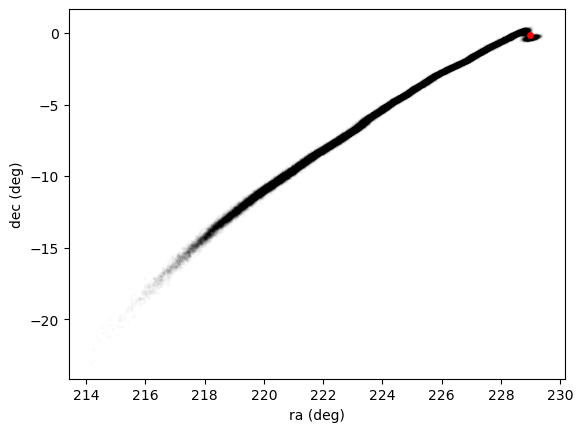

In [185]:
###Plot
## plot the track in the radec frame to see how it would appears from an observer on earth
# %matplotlib inline
plt.figure()
plt.scatter(icrs_ps.ra.deg, icrs_ps.dec.deg, s=3, c='k', alpha=0.01)
plt.scatter(ra_prog, dec_prog, s=15, c='r')#progenitor
plt.xlabel("ra (deg)")
plt.ylabel("dec (deg)")
# plt.title("Stellar Stream (ICRS)")
plt.show()

Text(37.597222222222214, 0.5, '$\\phi_2$ (deg)')

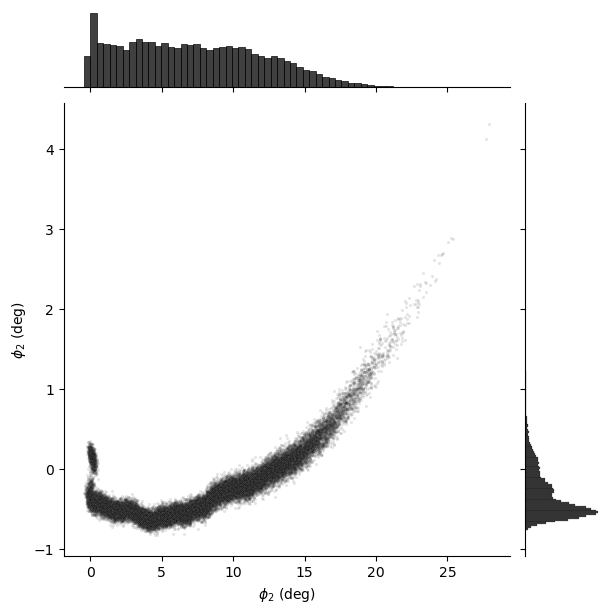

In [64]:
sns.jointplot(x=phi12_ps.phi1, y=phi12_ps.phi2, alpha=0.1,s=5, color='k')
# ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
plt.xlabel(r"$\phi_2$ (deg)")
plt.ylabel(r"$\phi_2$ (deg)")

Sample magnitudes

In [59]:
###Librairires for simulation and 
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities
from galpy.df import streampepperdf #Extension to perform multiple impact
import stream_galsim.impact_distribution as sid; reload(sid)

/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py:446: SyntaxWarning: invalid escape sequence '\o'
  axs[2].set_title("Subhalo masses")



<module 'stream_galsim.impact_distribution' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py'>

In [ ]:
config = {
    "name": "Bressan2012",
    "survey": "des",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}
isochrone_model = sutils.IsochroneModel(config)

mag_g_s, mag_r_s = isochrone_model.sample_magnitudes(phi12_ps, addnoise=True, sigma_mag=0.01)

In [66]:
# Save stars table with sampled magnitudes
sutils.save_star_data(phi12_ps, mag_g_s, mag_r_s, 'phi12', filepath=f"/home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Peppered_Pal5_stars.csv")

Pandas DataFrame saved to: /home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Peppered_Pal5_stars.csv


,phi1,phi2,dist,mu1,mu2,rv,mag_g,mag_r
0,3.458951,-0.598494,22.496870,NaN,NaN,NaN,26.947628,25.793413
1,0.052110,0.321144,23.023163,NaN,NaN,NaN,28.629650,27.231826
2,1.111968,-0.479831,23.146718,NaN,NaN,NaN,31.230340,29.510918
3,15.112686,0.077712,19.456133,NaN,NaN,NaN,24.850991,24.004812
4,10.548521,-0.286025,20.580958,NaN,NaN,NaN,27.492727,26.244539
...,...,...,...,...,...,...,...,...
39995,12.348738,-0.067105,20.101738,NaN,NaN,NaN,27.401739,26.149540
39996,15.143050,0.137262,19.315620,NaN,NaN,NaN,25.840484,24.794617
39997,10.681980,-0.142941,20.580836,NaN,NaN,NaN,30.565133,28.906894
39998,24.345002,2.681346,16.901915,NaN,NaN,NaN,29.165217,27.612453


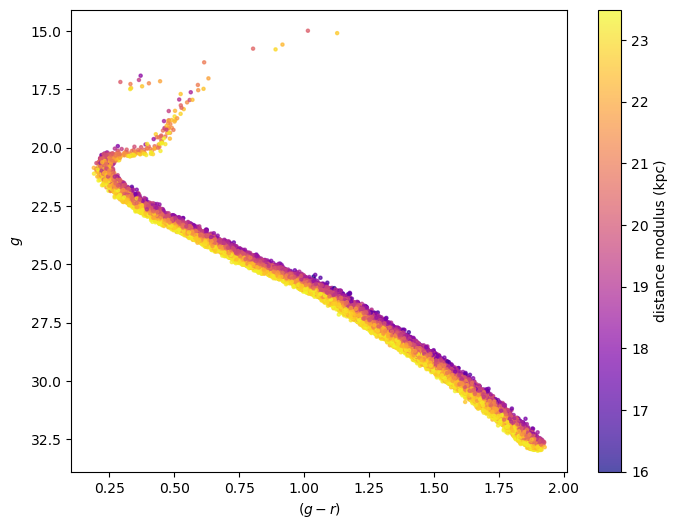

In [69]:
from astropy.table import Table

# Load the data
data_file = "/home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Peppered_Pal5_stars.csv"  # Path to the saved CSV
Pal_5_stars = Table.read(data_file, format="csv")

# Compute the color index (g-r)
color_index = Pal_5_stars["mag_g"] - Pal_5_stars["mag_r"]

# H-R diagram (Absolute mag vs. Color index)
plt.figure(figsize=(8, 6))
plt.scatter(color_index, Pal_5_stars["mag_g"], s=5, c=Pal_5_stars["dist"], cmap="plasma", alpha=0.7)

# Flip the y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels
plt.xlabel(r"$(g - r)$")
plt.ylabel(r"$g$")
# plt.title(f"H-R Diagram (Pal5, age = {12.0}, z = 0.0006)")

# Colorbar
plt.colorbar(label="distance modulus (kpc)")

# Show the plot
plt.show()


In [70]:
print(len(Pal_5_stars))#[(Pal_5_stars["mag_g"]<27.5)&(Pal_5_stars["mag_g"]>20)]))

40000


# Applying stream search module

We apply 2 methods of stream search:
 - match_filtering from injection Lsst updated notebook
 - density map analysis, to estimate the region the streams belong to, within the fov

In [334]:
###We load the file computed from injection_Lsst_updated
data_file = f"../data/Filtered_Peppered_Pal5_stars.csv"  # Path to the saved CSV
Mag_Filtered_stars = pd.read_csv(data_file)
Mag_Filtered_stars[Mag_Filtered_stars['flag']=='1']

,ra,dec,mag_g,magerr_g,mag_r,magerr_r,extendedness,flag
454266,65.027930,-30.618193,25.506380,0.060343,24.644913,0.031861,NaN,1
454267,61.551837,-34.112765,24.944969,0.039567,24.095771,0.023251,NaN,1
454268,66.429493,-29.164062,24.196514,0.023598,23.549169,0.015880,NaN,1
454269,66.988274,-28.739534,25.639413,0.061627,24.679375,0.033385,NaN,1
454270,64.076253,-31.537484,21.762165,0.007116,21.477872,0.006778,NaN,1
...,...,...,...,...,...,...,...,...
457318,62.917832,-32.927931,20.349002,0.005814,20.078942,0.005693,NaN,1
457319,67.895658,-28.171075,25.953023,0.086558,24.889217,0.040225,NaN,1
457320,63.997148,-31.651886,21.120438,0.006269,20.865875,0.006151,NaN,1
457321,63.442876,-32.189489,24.673989,0.032989,23.927527,0.020205,NaN,1


The function employs a simple method:
- creates a 2D histogram (so you have to choose the binning as input)
- calculates the average density (background)
- rejects bins that are below a (threshold * background)
- keeps the bins that are above and those that are right next to it (to preserve an area around the stream)
- returns as output a filtered 2D histogram as well as the table of stars that were kept.

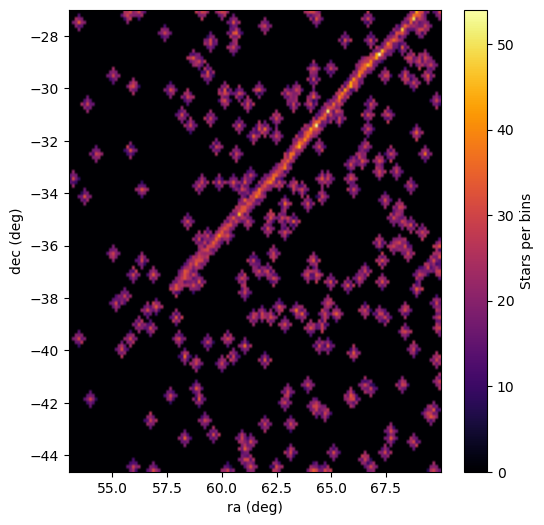

,ra,dec,mag_g,magerr_g,mag_r,magerr_r,extendedness,flag
454266,65.027930,-30.618193,25.506380,0.060343,24.644913,0.031861,NaN,1
454267,61.551837,-34.112765,24.944969,0.039567,24.095771,0.023251,NaN,1
454268,66.429493,-29.164062,24.196514,0.023598,23.549169,0.015880,NaN,1
454269,66.988274,-28.739534,25.639413,0.061627,24.679375,0.033385,NaN,1
454270,64.076253,-31.537484,21.762165,0.007116,21.477872,0.006778,NaN,1
...,...,...,...,...,...,...,...,...
457318,62.917832,-32.927931,20.349002,0.005814,20.078942,0.005693,NaN,1
457319,67.895658,-28.171075,25.953023,0.086558,24.889217,0.040225,NaN,1
457320,63.997148,-31.651886,21.120438,0.006269,20.865875,0.006151,NaN,1
457321,63.442876,-32.189489,24.673989,0.032989,23.927527,0.020205,NaN,1


In [387]:
premask = (Mag_Filtered_stars['ra']<70) & (Mag_Filtered_stars['ra']>53) & (Mag_Filtered_stars['dec']<-27)
Density_Filtering =sutils.StreamDensityFiltering(data=Mag_Filtered_stars[premask], bins=(130,130), threshold=1.54, buffer=2)
#plot
%matplotlib inline
Density_Filtering.plot(filtered=True, cmap='inferno')

#table
Filtered_stars = Density_Filtering.values()
# _, Filtered_hist = Density_Filtering.values(return_hist=True)
Filtered_stars[Filtered_stars['flag']=='1']

Rotating in proper stream frame and cut

In [338]:
#phi12
pole1 = ac.SkyCoord(ra=70*u.deg, dec=-25.5*u.deg)
pole2 = ac.SkyCoord(ra=60*u.deg, dec=-35*u.deg)
Filtered_stars_phi12 = sutils.icrs_to_phi12(Filtered_stars, pole1, pole2, velocities = False, panda=True)
Filtered_stars_phi12

,ra,dec,mag_g,magerr_g,mag_r,magerr_r,extendedness,flag,phi1,phi2,distance
5596,55.868976,-44.597974,20.956270,0.002621,20.687160,0.001774,0.0,DC2,21.774334,4.712507,999.0
5598,55.775969,-44.616920,19.997068,0.001424,19.722759,0.001000,0.0,DC2,21.836015,4.681455,999.0
5599,55.808806,-44.604322,21.900544,0.004891,21.605581,0.003573,0.0,DC2,21.810212,4.688071,999.0
5600,55.749068,-44.611421,25.812675,0.130983,24.616049,0.050260,0.0,DC2,21.846386,4.664423,999.0
5602,55.816554,-44.577311,25.397008,0.082517,24.331849,0.036576,0.0,DC2,21.787747,4.671985,999.0
...,...,...,...,...,...,...,...,...,...,...,...
457318,62.917832,-32.927931,20.349002,0.005814,20.078942,0.005693,NaN,1,9.653025,0.296005,999.0
457319,67.895658,-28.171075,25.953023,0.086558,24.889217,0.040225,NaN,1,3.251358,0.296668,999.0
457320,63.997148,-31.651886,21.120438,0.006269,20.865875,0.006151,NaN,1,8.097572,0.092800,999.0
457321,63.442876,-32.189489,24.673989,0.032989,23.927527,0.020205,NaN,1,8.811648,0.113751,999.0


We finally have our complete filtered stream, which is clearly visible on the map, allowing to perform a final cut

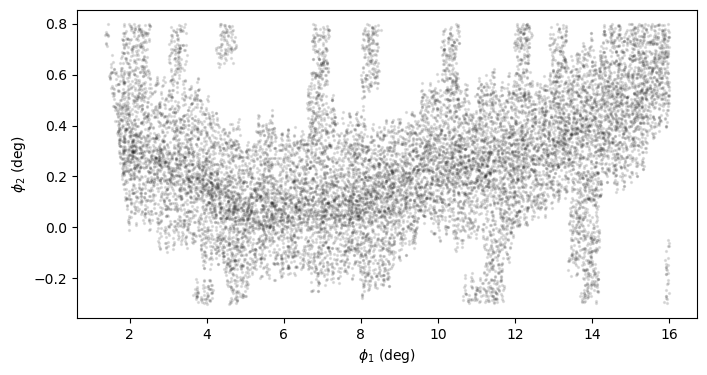

In [ ]:
final_mask = (Filtered_stars_phi12.phi1>-1) & (Filtered_stars_phi12.phi1<16) & (Filtered_stars_phi12.phi2<0.8) & (Filtered_stars_phi12.phi2>-0.3) 
final_stream = Filtered_stars_phi12[final_mask]

plt.figure(figsize=(8,4))
plt.scatter(final_stream.phi1, final_stream.phi2, alpha=0.2,s=2, color='k')
plt.xlabel(r"$\phi_1$ (deg)")
plt.ylabel(r"$\phi_2$ (deg)")
plt.show()

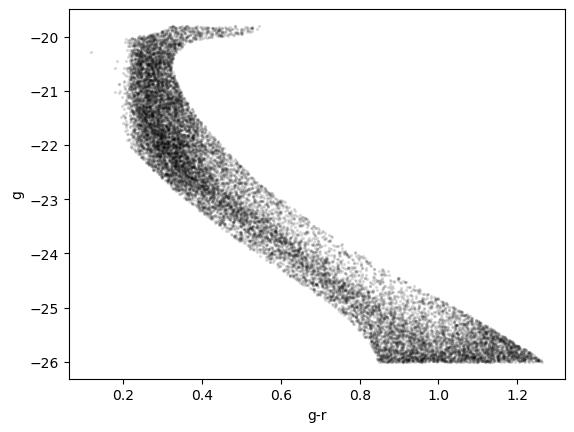

In [384]:

plt.figure()
plt.scatter(final_stream.mag_g - final_stream.mag_r, -final_stream.mag_g, alpha=0.1,s=2, color='k')
plt.ylabel("g")
plt.xlabel("g-r")
plt.show()

# Constructing the Power spectrum

We finally have a map holding the selected stars with the highest probability of belonging to Palomar 5, in a realistic environment. It remains thus two steps to compute the power spectrum: Compute the linear density then the power spectrum itself.

## Interpolating the density and the density contrast

First comparison between the unperturbed and the perturbed stream_df

In [366]:
## Plot difference between perturbed and non perturbed vs non-perturbed

plt.figure(figsize=(8, 4))
plt.plot(X_s, X_ps-X_s, 'x')
plt.xlabel(r'$angle $ (°)')
plt.ylabel(r'$\Delta$ (°)')
plt.title(r'Position difference in angle of stars along stream track')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (100000,) (40000,) 

<Figure size 800x400 with 0 Axes>

Inferring the linear density along Phi1

In [367]:
final_stream

,ra,dec,mag_g,magerr_g,mag_r,magerr_r,extendedness,flag,phi1,phi2,distance
169866,58.166371,-37.572279,21.052912,0.001650,20.757178,0.001125,0.0,DC2,15.682626,0.796158,999.0
169868,58.080888,-37.569036,22.013788,0.003179,21.650137,0.002271,0.0,DC2,15.729124,0.746767,999.0
169869,58.115109,-37.568445,23.405229,0.009198,22.840340,0.005772,0.0,DC2,15.709192,0.765175,999.0
169870,57.981350,-37.418845,23.828867,0.013710,23.279690,0.008389,0.0,DC2,15.681786,0.583813,999.0
169871,58.198424,-37.541632,25.616381,0.062316,24.787003,0.033112,0.0,DC2,15.643053,0.791782,999.0
...,...,...,...,...,...,...,...,...,...,...,...
457318,62.917832,-32.927931,20.349002,0.005814,20.078942,0.005693,NaN,1,9.653025,0.296005,999.0
457319,67.895658,-28.171075,25.953023,0.086558,24.889217,0.040225,NaN,1,3.251358,0.296668,999.0
457320,63.997148,-31.651886,21.120438,0.006269,20.865875,0.006151,NaN,1,8.097572,0.092800,999.0
457321,63.442876,-32.189489,24.673989,0.032989,23.927527,0.020205,NaN,1,8.811648,0.113751,999.0


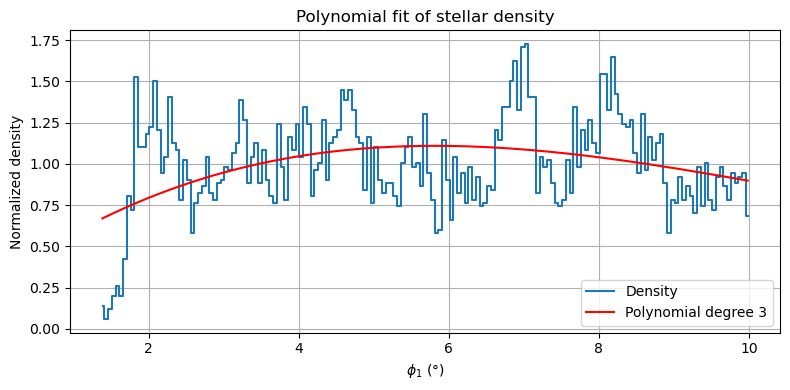

In [368]:
### we use the StreamDensityAnalyzer class from sutils
phi1_mask = (final_stream.phi1 > 0) & (final_stream.phi1 < 10)
Stream_Density_Analyzer = sutils.StreamDensityAnalyzer(final_stream[phi1_mask], bin_width=0.05)
phi1_bins, phi1_densities = Stream_Density_Analyzer.compute_density(plot=False, normalize=True)
# coeffs_perturbed, poly_func_perturbed = Stream_Density_Analyzer.fit_polynomial(degree=8, plot=True) #not necessary
coeffs_smooth, poly_smooth = Stream_Density_Analyzer.fit_polynomial(degree=3, plot=True) 

In [369]:
###Computing the density contrast using smooth density
delta_real = (phi1_densities-poly_smooth(phi1_bins))/poly_smooth(phi1_bins)


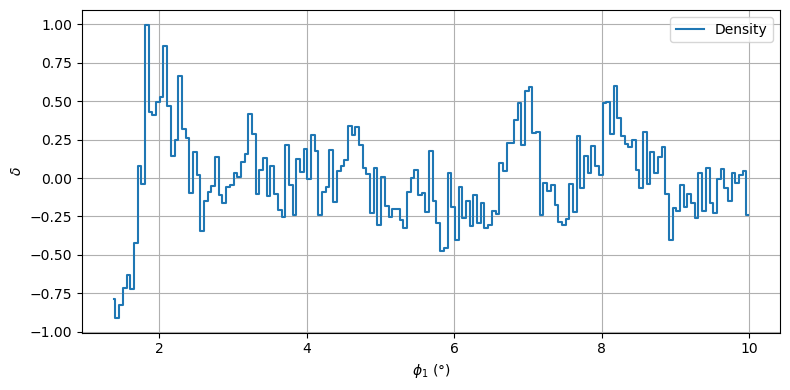

In [370]:
plt.figure(figsize=(8, 4))
# plt.plot(centers, (dens_norm_perturbed-dens_norm_unperturbed)/dens_norm_unperturbed, drawstyle='steps-mid')
plt.plot(phi1_bins, delta_real, label="Density", drawstyle='steps-mid')
plt.xlabel(r'$\phi_1$ (°)')
plt.ylabel(r"$\delta$")
# plt.title("Density contrast along the stream track")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Computing the power spectrum of the linear density contrast

In [371]:
###Librairires for simulation and 
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities
from galpy.df import streampepperdf #Extension to perform multiple impact
import stream_galsim.impact_distribution as sid; reload(sid)

<module 'stream_galsim.impact_distribution' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py'>

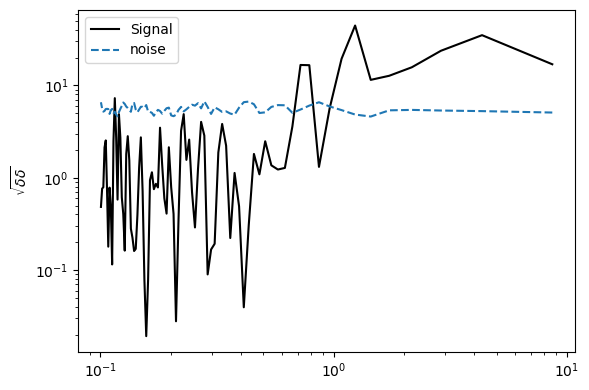

In [372]:
#using PowerSpectrum1D class from sutils

pspec_real = sid.PowerSpectrum1D(delta=delta_real, xi=phi1_bins)
pspec_real.compute()
pspec_real.noise_compute()
pspec_real.plot(xscale='size')

## Same thing but with the unoised data

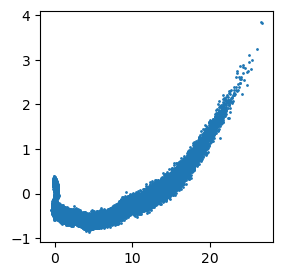

In [321]:
plt.figure(figsize=(3,3))
plt.scatter(phi12_ps.phi1, phi12_ps.phi2, s=1)
plt.show()

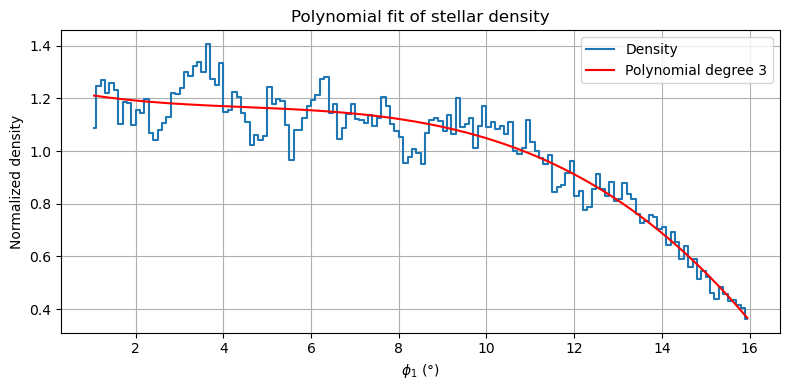

In [326]:
### we use the StreamDensityAnalyzer class from sutils
phi1_mask = (phi12_ps.phi1.deg > 1) & (phi12_ps.phi1.deg < 16)
Stream_Density_Analyzer_Ideal = sutils.StreamDensityAnalyzer(phi12_ps[phi1_mask], bin_width=0.1)
phi1_bins_ideal, phi1_densities_ideal = Stream_Density_Analyzer_Ideal.compute_density(plot=False, normalize=True)
# coeffs_perturbed, poly_func_perturbed = Stream_Density_Analyzer.fit_polynomial(degree=8, plot=True) #not necessary
coeffs_smooth_ideal, poly_smooth_ideal = Stream_Density_Analyzer_Ideal.fit_polynomial(degree=3, plot=True) 

In [327]:
###Computing the density contrast using smooth density
delta_ideal = (phi1_densities_ideal-poly_smooth(phi1_bins_ideal))/poly_smooth(phi1_bins_ideal)

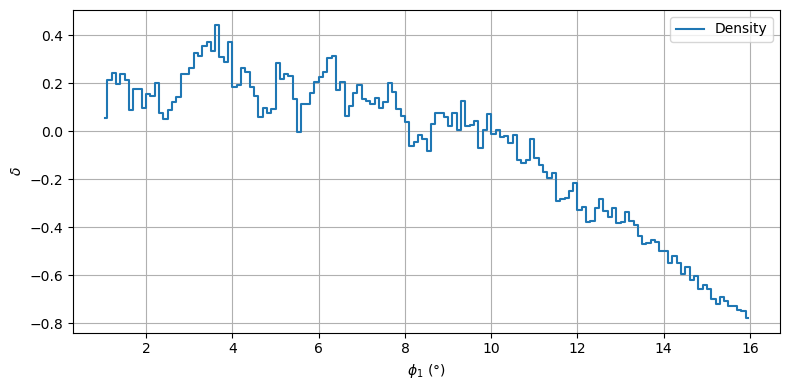

In [328]:
plt.figure(figsize=(8, 4))
# plt.plot(centers, (dens_norm_perturbed-dens_norm_unperturbed)/dens_norm_unperturbed, drawstyle='steps-mid')
plt.plot(phi1_bins_ideal, delta_ideal, label="Density", drawstyle='steps-mid')
plt.xlabel(r'$\phi_1$ (°)')
plt.ylabel(r"$\delta$")
# plt.title("Density contrast along the stream track")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

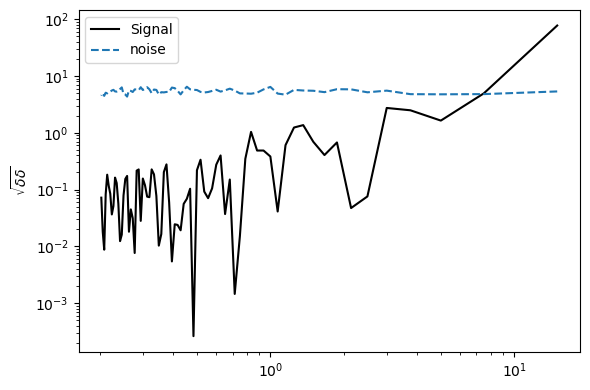

In [329]:
pspec_ideal = sid.PowerSpectrum1D(delta=delta_ideal, xi=phi1_bins_ideal)
pspec_ideal.compute()
pspec_ideal.noise_compute()
pspec_ideal.plot(xscale='size')